<a href="https://colab.research.google.com/github/asurkis/dls-homework-16/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%5Bhw%5Dsemantic_segmentation_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Курс "Глубокое обучение". Первый семестр</b></h3>

# Домашнее задание. Сегментация изображений

---


1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>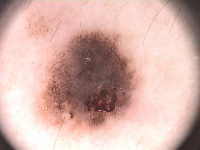</td><td>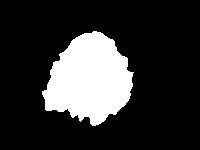</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

In [1]:
! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
! unrar x PH2Dataset.rar

--2020-12-16 11:26:03--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2020-12-16 11:26:03--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4586acf579619b3ca570b7e2eb.dl.dropboxusercontent.com/cd/0/inline/BFJQO9MboFmmBFMsi6ulzJuPCTJOZnKvtMMCW8e73s9DtudAEZ-0hygcdugTvN8LVDK6P-VrSzbw4WE3tnBkLmo8ULNPFib1fZJi4xFoinLyxA/file# [following]
--2020-12-16 11:26:03--  https://uc4586acf579619b3ca570b7e2eb.dl.dropboxusercontent.com/cd/0/inline/BFJQO9MboFmmBFMsi6ulzJuPCTJOZnKvtMMCW8e73s9DtudAEZ-0hygcdugTvN8LVDK6P-VrSzbw4WE3tnBkLmo8ULNPFib1fZJi4xFoinLyxA/file
Resolving 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [3]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [4]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

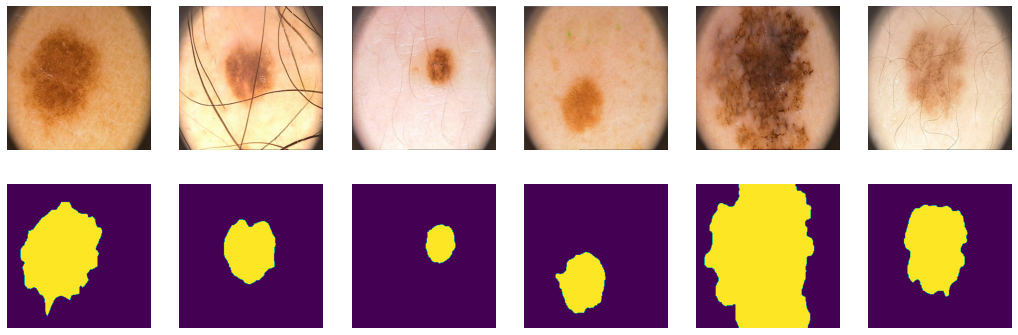

In [6]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [8]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [9]:
from torch.utils.data import DataLoader
# Пришлось уменьшить, чтобы хватало памяти для CUDA
batch_size = 10
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# Без периодического выполнения этого кода весьма скоро натыкаюсь на CUDA out of memory
torch.cuda.empty_cache()
!nvidia-smi

Tue Dec 15 14:30:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

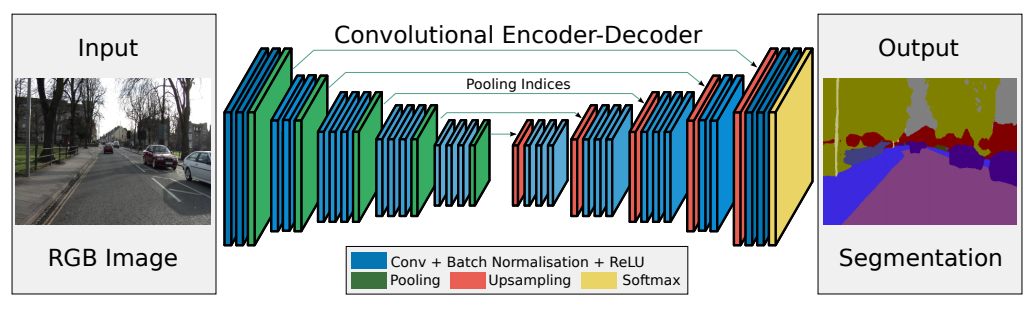

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [11]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, return_indices=True)
        self.enc_conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.enc_conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, return_indices=True)
        self.enc_conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.enc_conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.enc_conv7 = nn.Conv2d(256, 256, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, return_indices=True)
        self.enc_conv8 = nn.Conv2d(256, 512, 3, padding=1)
        self.enc_conv9 = nn.Conv2d(512, 512, 3, padding=1)
        self.enc_conv10 = nn.Conv2d(512, 512, 3, padding=1)
        self.pool4 = nn.MaxPool2d(2, return_indices=True)
        self.enc_conv11 = nn.Conv2d(512, 512, 3, padding=1)
        self.enc_conv12 = nn.Conv2d(512, 512, 3, padding=1)
        self.enc_conv13 = nn.Conv2d(512, 512, 3, padding=1)
        self.pool5 = nn.MaxPool2d(2, return_indices=True)

        self.upsample1 = nn.MaxUnpool2d(2)
        self.dec_conv1 = nn.Conv2d(512, 512, 3, padding=1)
        self.dec_conv2 = nn.Conv2d(512, 512, 3, padding=1)
        self.dec_conv3 = nn.Conv2d(512, 512, 3, padding=1)
        self.upsample2 = nn.MaxUnpool2d(2)
        self.dec_conv4 = nn.Conv2d(512, 512, 3, padding=1)
        self.dec_conv5 = nn.Conv2d(512, 256, 3, padding=1)
        self.upsample3 = nn.MaxUnpool2d(2)
        self.dec_conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.dec_conv7 = nn.Conv2d(256, 256, 3, padding=1)
        self.dec_conv8 = nn.Conv2d(256, 128, 3, padding=1)
        self.upsample4 = nn.MaxUnpool2d(2)
        self.dec_conv9 = nn.Conv2d(128, 128, 3, padding=1)
        self.dec_conv10 = nn.Conv2d(128, 128, 3, padding=1)
        self.dec_conv11 = nn.Conv2d(128, 64, 3, padding=1)
        self.unsample5 = nn.MaxUnpool2d(2)
        self.dec_conv12 = nn.Conv2d(64, 64, 3, padding=1)
        self.dec_conv13 = nn.Conv2d(64, 1, 3, padding=1)

        self.bn = nn.BatchNorm2d(batch_size)

    def forward(self, x):
        x = F.relu(self.enc_conv1(x))
        t = F.relu(self.enc_conv2(x))
        del x
        x = t
        t, i1 = self.pool1(x)
        del x
        x = t
        x = F.relu(self.enc_conv3(x))
        x = F.relu(self.enc_conv4(x))
        x, i2 = self.pool2(x)
        x = F.relu(self.enc_conv5(x))
        x = F.relu(self.enc_conv6(x))
        x = F.relu(self.enc_conv7(x))
        x, i3 = self.pool3(x)
        x = F.relu(self.enc_conv8(x))
        x = F.relu(self.enc_conv9(x))
        x = F.relu(self.enc_conv10(x))
        x, i4 = self.pool4(x)
        x = F.relu(self.enc_conv11(x))
        x = F.relu(self.enc_conv12(x))
        x = F.relu(self.enc_conv13(x))
        x, i5 = self.pool5(x)

        x = self.upsample1(x, i5)
        x = F.relu(self.dec_conv1(x))
        x = F.relu(self.dec_conv2(x))
        x = F.relu(self.dec_conv3(x))
        x = self.upsample2(x, i4)
        x = F.relu(self.dec_conv4(x))
        x = F.relu(self.dec_conv5(x))
        x = F.relu(self.dec_conv6(x))
        x = self.upsample2(x, i3)
        x = F.relu(self.dec_conv7(x))
        x = F.relu(self.dec_conv8(x))
        x = F.relu(self.dec_conv9(x))
        x = self.upsample2(x, i2)
        x = F.relu(self.dec_conv10(x))
        x = F.relu(self.dec_conv11(x))
        x = self.upsample2(x, i1)
        x = F.relu(self.dec_conv12(x))
        x = self.dec_conv13(x)

        # Т.к. выход у нас от 0 до 1, то можно нормализовать сигмоидой
        # return torch.sigmoid(x)
        return self.bn(x.transpose(0, 1)).transpose(0, 1)

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape

    # Один класс меньше среднего
    # другой больше
    outputs = (outputs > torch.mean(outputs)).squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь [1 балл]

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
# bce_loss_obj = nn.BCELoss()

def bce_loss(y_real, y_pred):
    # Вариант по определению
    # prob = torch.sigmoid(y_pred)
    # return -torch.sum(y_real * torch.log(prob) + (1 - y_real) * torch.log(1 - prob))

    # Оптимизированный вариант
    # Использую mean, потому что с суммой loss зависит от размера батча,
    # и градиент на каждом шаге может получаться очень большим
    return torch.mean(y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred) + 1e-8))

    # Эталонный вариант, который по заданию использовать нельзя
    # return bce_loss_obj(torch.sigmoid(y_pred), y_real)
    # TODO 
    # please don't use nn.BCELoss. write it from scratch

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
import gc

def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    history = {
        'loss_tr': [],
        'loss_val': [],
        'score_tr': [],
        'score_val': [] }

    for epoch in range(epochs):
        # torch.cuda.empty_cache()
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            xb_cuda = X_batch.to(device)
            yb_cuda = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(xb_cuda)
            loss = loss_fn(yb_cuda, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        with torch.no_grad():
            Y_hat = model(X_val.to(device)).cpu().detach() # detach and put into cpu

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(Y_val[k, 0], cmap='gray')
            plt.title('Expected')
            plt.axis('off')
        # plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))

        history['loss_tr'].append(avg_loss.item())
        history['loss_val'].append(loss_fn(Y_val, Y_hat).item())

        # gc.collect()
        # torch.cuda.empty_cache()
        score = score_model(model, iou_pytorch, data_tr)
        history['score_tr'].append(score)

        # gc.collect()
        # torch.cuda.empty_cache()
        score = score_model(model, iou_pytorch, data_val)
        history['score_val'].append(score)

        plt.suptitle('%d/%d -- ' % (epoch + 1, epochs) +
                     '; '.join(['%s = %f' % (key, history[key][-1]) for key in history]))
        plt.show()
    return history

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [ ]:
max_epochs = 200

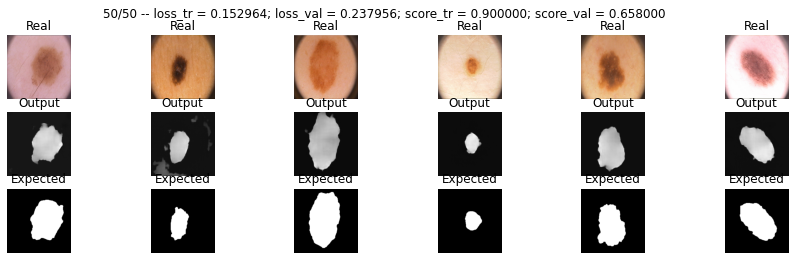

In [ ]:
# segnet_bce = SegNet().to(device)
# optim = torch.optim.Adam(segnet_bce.parameters())
history_segnet_bce_2 = train(segnet_bce, optim, bce_loss, max_epochs, data_tr, data_val)
for key in history_segnet_bce:
    history_segnet_bce[key].extend(history_segnet_bce_2[key])

import pandas as pd
pd.DataFrame(history_segnet_bce).to_csv('/content/drive/MyDrive/HomeworkSegmentation/history_segnet_bce.csv')
torch.save(segnet_bce, '/content/drive/MyDrive/HomeworkSegmentation/segnet_bce.model')

Ответьте себе на вопрос: не переобучается ли моя модель?

**Значительно переобучается:
на обучающей выборке score близок к 1,
в то время как на тестовой &mdash; 0.7.**

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало, прежде чем бить тревогу попробуйте поперебирать различные варианты, убедитесь, что во всех других сетапах сетть достигает желанного результата. СПОЙЛЕР: учиться она будеет при всех лоссах предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникаемой в математической формуле.


In [ ]:
def dice_loss(y_real, y_pred):
    y_real = torch.sigmoid(y_real)
    y_pred = torch.sigmoid(y_pred)
    num = y_real * y_pred
    den = y_real + y_pred
    # Константы можно опустить, т.к. константа в сумме не влияет на градиент,
    # а коэффициент компенсируется динамическим learning rate
    res = 1 - torch.mean(num / den)
    return res

Проводим тестирование:

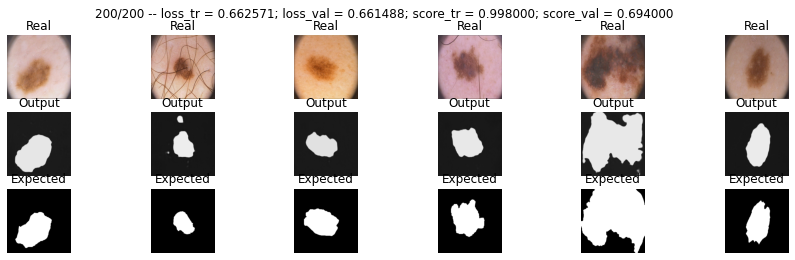

In [ ]:
segnet_dice = SegNet().to(device)
optimaizer = torch.optim.Adam(segnet_dice.parameters())
history_segnet_dice = train(segnet_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)
pd.DataFrame(history_segnet_dice).to_csv('/content/drive/MyDrive/HomeworkSegmentation/history_segnet_dice.csv')
torch.save(segnet_dice, '/content/drive/MyDrive/HomeworkSegmentation/segnet_dice.model')

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps=1e-8, gamma=2.0):
    # y_pred =  # hint: torch.clamp
    s = torch.sigmoid(y_pred)
    # Почему mean вместо sum -- писал выше
    return -torch.mean((1 - s + eps) ** gamma * y_real * torch.log(s + eps) + (1 - y_real + eps) * torch.log(1 - s + eps))

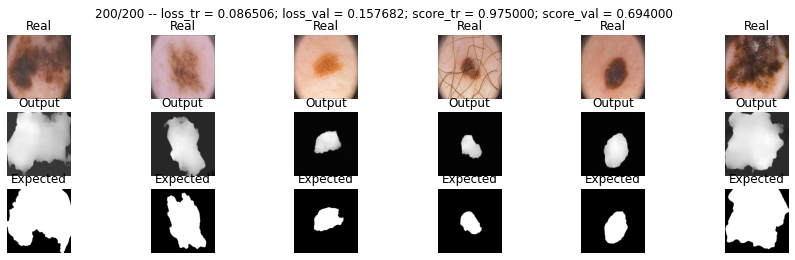

In [ ]:
segnet_focal = SegNet().to(device)
optimaizer = torch.optim.Adam(segnet_focal.parameters())
history_segnet_focal = train(segnet_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)
pd.DataFrame(history_segnet_focal).to_csv('/content/drive/MyDrive/HomeworkSegmentation/history_segnet_focal.csv')
torch.save(segnet_focal, '/content/drive/MyDrive/HomeworkSegmentation/segnet_focal.model')

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

**Я выбрал Correlation Maximized Structural Similarity Loss for Semantic Segmentation (4 пункт из списка)**

In [ ]:
def correlation_loss(y_real, y_pred):
    C4 = 0.01
    beta = 0.1

    var_real, mean_real = torch.var_mean(y_real)
    var_pred, mean_pred = torch.var_mean(y_pred)
    cov = torch.mean((y_real - mean_real) * (y_pred - mean_pred))

    e = torch.abs((y_real - mean_real + C4) / (torch.sqrt(var_real) + C4) -
                  (y_pred - mean_pred + C4) / (torch.sqrt(var_pred) + C4))
    L_ce = -y_real * torch.log(torch.sigmoid(y_pred))
    L_ssl = e * L_ce
    return torch.mean(L_ssl)

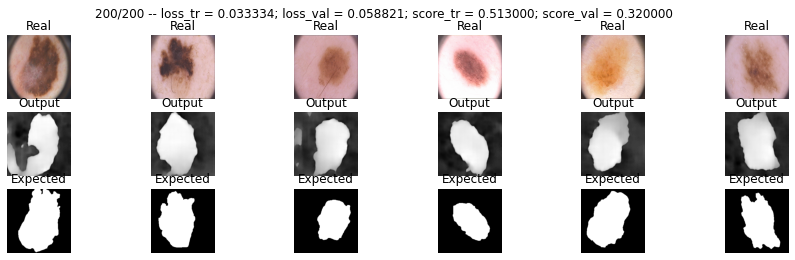

In [ ]:
segnet_correlation = SegNet().to(device)
optimaizer = torch.optim.Adam(segnet_correlation.parameters())
history_segnet_correlation = train(segnet_correlation, optimaizer, correlation_loss, max_epochs, data_tr, data_val)
pd.DataFrame(history_segnet_correlation).to_csv('/content/drive/MyDrive/HomeworkSegmentation/history_segnet_correlation.csv')
torch.save(segnet_correlation, '/content/drive/MyDrive/HomeworkSegmentation/segnet_correlation.model')

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

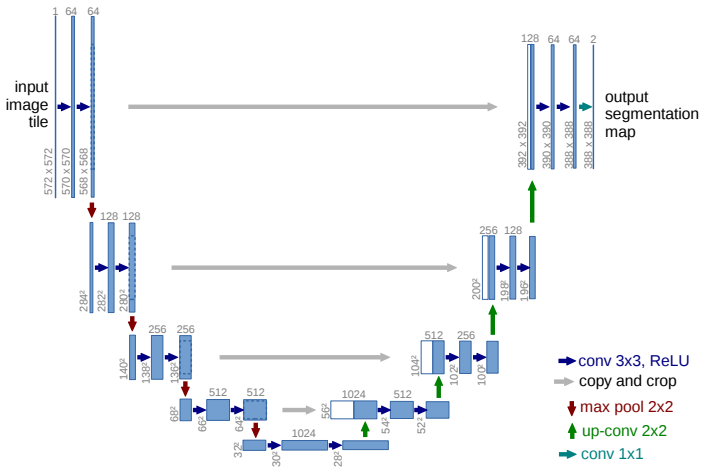

У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [12]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Сделать нормальное отражение входных данных мне не удалось,
        # потому что в итоге я прихожу к нечетному размеру слоя после апскейла
        
        # Поэтому делаю паддинг

        self.enc_conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, return_indices=True)
        self.enc_conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.enc_conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, return_indices=True)
        self.enc_conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.enc_conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, return_indices=True)
        self.enc_conv7 = nn.Conv2d(256, 512, 3, padding=1)
        self.enc_conv8 = nn.Conv2d(512, 512, 3, padding=1)
        self.pool4 = nn.MaxPool2d(2, return_indices=True)

        self.bottleneck_conv1 = nn.Conv2d(512, 1024, 3, padding=1)
        self.bottleneck_conv2 = nn.Conv2d(1024, 512, 3, padding=1)

        self.unpool1 = nn.MaxUnpool2d(2)
        self.dec_conv1 = nn.Conv2d(1024, 512, 3, padding=1)
        self.dec_conv2 = nn.Conv2d(512, 256, 3, padding=1)
        self.unpool2 = nn.MaxUnpool2d(2)
        self.dec_conv3 = nn.Conv2d(512, 256, 3, padding=1)
        self.dec_conv4 = nn.Conv2d(256, 128, 3, padding=1)
        self.unpool3 = nn.MaxUnpool2d(2)
        self.dec_conv5 = nn.Conv2d(256, 128, 3, padding=1)
        self.dec_conv6 = nn.Conv2d(128, 64, 3, padding=1)
        self.unpool4 = nn.MaxUnpool2d(2)
        self.dec_conv7 = nn.Conv2d(128, 64, 3, padding=1)
        self.dec_conv8 = nn.Conv2d(64, 64, 3, padding=1)
        self.dec_conv9 = nn.Conv2d(64, 1, 1)

        self.bn = nn.BatchNorm2d(batch_size)

    def forward(self, x):
        xx = F.relu(self.enc_conv1(x))
        s1 = F.relu(self.enc_conv2(xx))
        xx, i1 = self.pool1(s1)
        xx = F.relu(self.enc_conv3(xx))
        s2 = F.relu(self.enc_conv4(xx))
        xx, i2 = self.pool2(s2)
        xx = F.relu(self.enc_conv5(xx))
        s3 = F.relu(self.enc_conv6(xx))
        xx, i3 = self.pool3(s3)
        xx = F.relu(self.enc_conv7(xx))
        s4 = F.relu(self.enc_conv8(xx))
        xx, i4 = self.pool4(s4)
        xx = F.relu(self.bottleneck_conv1(xx))
        xx = F.relu(self.bottleneck_conv2(xx))
        xx = self.unpool1(xx, i4)
        cat = torch.cat([xx, s4], 1)
        xx = F.relu(self.dec_conv1(cat))
        xx = F.relu(self.dec_conv2(xx))
        xx = self.unpool2(xx, i3)
        cat = torch.cat([xx, s3], 1)
        xx = F.relu(self.dec_conv3(cat))
        xx = F.relu(self.dec_conv4(xx))
        xx = self.unpool3(xx, i2)
        cat = torch.cat([xx, s2], 1)
        xx = F.relu(self.dec_conv5(cat))
        xx = F.relu(self.dec_conv6(xx))
        xx = self.unpool4(xx, i1)
        cat = torch.cat([xx, s1], 1)
        xx = F.relu(self.dec_conv7(cat))
        xx = F.relu(self.dec_conv8(xx))
        xx = self.dec_conv9(xx)
        return self.bn(xx.transpose(0, 1)).transpose(0, 1)

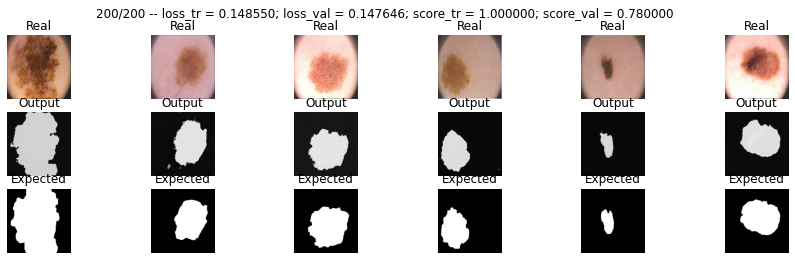

In [ ]:
unet_bce = UNet().to(device)
optimizer = torch.optim.Adam(unet_bce.parameters())
history_unet_bce = train(unet_bce, optimizer, bce_loss, max_epochs, data_tr, data_val)
pd.DataFrame(history_unet_bce).to_csv('/content/drive/MyDrive/HomeworkSegmentation/history_unet_bce.csv')
torch.save(unet_bce, '/content/drive/MyDrive/HomeworkSegmentation/unet_bce.model')

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [13]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.Conv2d(64, 64, 2, stride=2)
        self.enc_conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.enc_conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool2 = nn.Conv2d(128, 128, 2, stride=2)
        self.enc_conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.enc_conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.pool3 = nn.Conv2d(256, 256, 2, stride=2)
        self.enc_conv7 = nn.Conv2d(256, 512, 3, padding=1)
        self.enc_conv8 = nn.Conv2d(512, 512, 3, padding=1)
        self.pool4 = nn.Conv2d(512, 512, 2, stride=2)

        self.bottleneck_conv1 = nn.Conv2d(512, 1024, 3, padding=1)
        self.bottleneck_conv2 = nn.Conv2d(1024, 512, 3, padding=1)

        self.unpool1 = nn.ConvTranspose2d(512, 512, 2, stride=2)
        self.dec_conv1 = nn.Conv2d(1024, 512, 3, padding=1)
        self.dec_conv2 = nn.Conv2d(512, 256, 3, padding=1)
        self.unpool2 = nn.ConvTranspose2d(256, 256, 2, stride=2)
        self.dec_conv3 = nn.Conv2d(512, 256, 3, padding=1)
        self.dec_conv4 = nn.Conv2d(256, 128, 3, padding=1)
        self.unpool3 = nn.ConvTranspose2d(128, 128, 2, stride=2)
        self.dec_conv5 = nn.Conv2d(256, 128, 3, padding=1)
        self.dec_conv6 = nn.Conv2d(128, 64, 3, padding=1)
        self.unpool4 = nn.ConvTranspose2d(64, 64, 2, stride=2)
        self.dec_conv7 = nn.Conv2d(128, 64, 3, padding=1)
        self.dec_conv8 = nn.Conv2d(64, 64, 3, padding=1)
        self.dec_conv9 = nn.Conv2d(64, 1, 1)

        self.bn = nn.BatchNorm2d(batch_size)

    def forward(self, x):
        xx = F.relu(self.enc_conv1(x))
        s1 = F.relu(self.enc_conv2(xx))
        xx = self.pool1(s1)
        xx = F.relu(self.enc_conv3(xx))
        s2 = F.relu(self.enc_conv4(xx))
        xx = self.pool2(s2)
        xx = F.relu(self.enc_conv5(xx))
        s3 = F.relu(self.enc_conv6(xx))
        xx = self.pool3(s3)
        xx = F.relu(self.enc_conv7(xx))
        s4 = F.relu(self.enc_conv8(xx))
        xx = self.pool4(s4)
        xx = F.relu(self.bottleneck_conv1(xx))
        xx = F.relu(self.bottleneck_conv2(xx))
        xx = self.unpool1(xx)
        cat = torch.cat([xx, s4], 1)
        xx = F.relu(self.dec_conv1(cat))
        xx = F.relu(self.dec_conv2(xx))
        xx = self.unpool2(xx)
        cat = torch.cat([xx, s3], 1)
        xx = F.relu(self.dec_conv3(cat))
        xx = F.relu(self.dec_conv4(xx))
        xx = self.unpool3(xx)
        cat = torch.cat([xx, s2], 1)
        xx = F.relu(self.dec_conv5(cat))
        xx = F.relu(self.dec_conv6(xx))
        xx = self.unpool4(xx)
        cat = torch.cat([xx, s1], 1)
        xx = F.relu(self.dec_conv7(cat))
        xx = F.relu(self.dec_conv8(xx))
        xx = self.dec_conv9(xx)
        return self.bn(xx.transpose(0, 1)).transpose(0, 1)

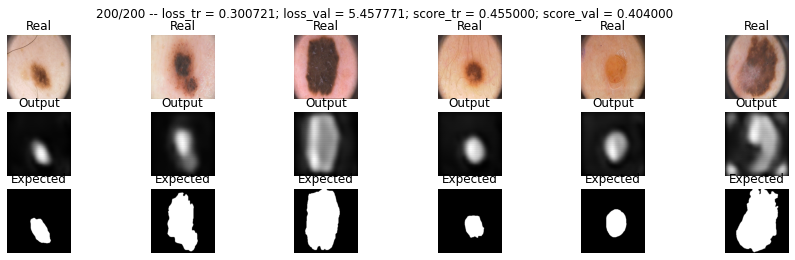

In [ ]:
unet2_model = UNet2().to(device)
optimizer = torch.optim.Adam(unet2_model.parameters())
history_unet2_bce = train(unet2_model, optimizer, bce_loss, max_epochs, data_tr, data_val)
pd.DataFrame(history_unet2_bce).to_csv('/content/drive/MyDrive/HomeworkSegmentation/history_unet2_bce.csv')
torch.save(unet2_model, '/content/drive/MyDrive/HomeworkSegmentation/unet2_bce.model')

Обучим UNet и UNet2 с разными лоссами и запишем историю обучения:

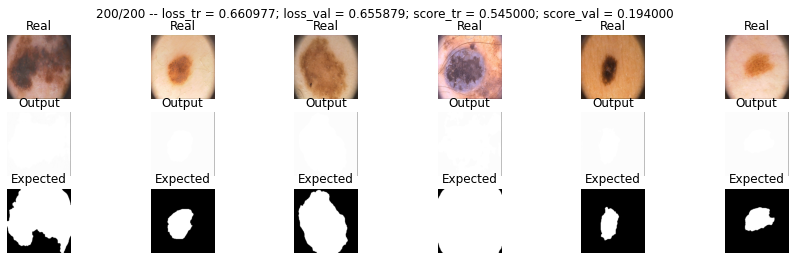

In [ ]:
unet_dice = UNet().to(device)
optimizer = torch.optim.Adam(unet_dice.parameters())
history_unet_dice = train(unet_dice, optimizer, dice_loss, max_epochs, data_tr, data_val)
pd.DataFrame(history_unet_dice).to_csv('/content/drive/MyDrive/HomeworkSegmentation/history_unet_dice.csv')
torch.save(unet_dice, '/content/drive/MyDrive/HomeworkSegmentation/unet_dice.model')

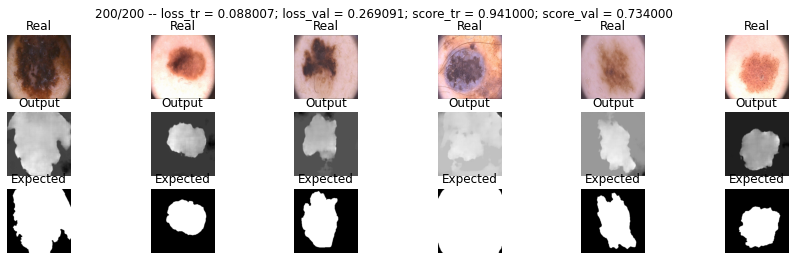

In [ ]:
unet_focal = UNet().to(device)
optimizer = torch.optim.Adam(unet_focal.parameters())
history_unet_focal = train(unet_focal, optimizer, focal_loss, max_epochs, data_tr, data_val)
pd.DataFrame(history_unet_focal).to_csv('/content/drive/MyDrive/HomeworkSegmentation/history_unet_focal.csv')
torch.save(unet_focal, '/content/drive/MyDrive/HomeworkSegmentation/unet_focal.model')

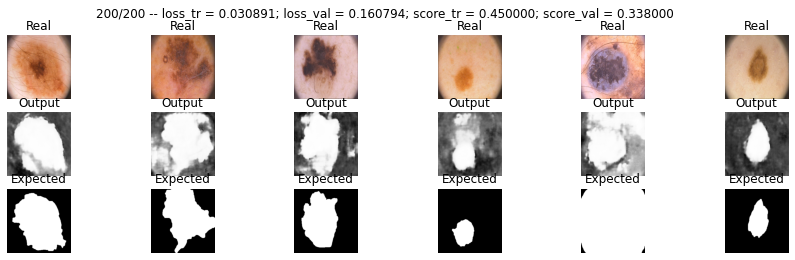

In [ ]:
unet_correlation = UNet().to(device)
optimizer = torch.optim.Adam(unet_correlation.parameters())
history_unet_correlation = train(unet_correlation, optimizer, correlation_loss, max_epochs, data_tr, data_val)
pd.DataFrame(history_unet_correlation).to_csv('/content/drive/MyDrive/HomeworkSegmentation/history_unet_correlation.csv')
torch.save(unet_correlation, '/content/drive/MyDrive/HomeworkSegmentation/unet_correlation.model')

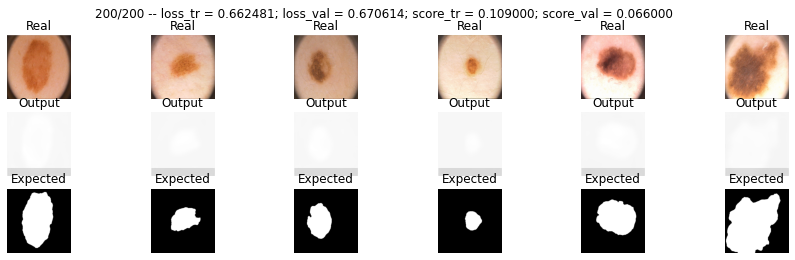

In [ ]:
unet2_dice = UNet2().to(device)
optimizer = torch.optim.Adam(unet2_dice.parameters())
history_unet2_dice = train(unet2_dice, optimizer, dice_loss, max_epochs, data_tr, data_val)
pd.DataFrame(history_unet2_dice).to_csv('/content/drive/MyDrive/HomeworkSegmentation/history_unet2_dice.csv')
torch.save(unet2_dice, '/content/drive/MyDrive/HomeworkSegmentation/unet2_dice.model')

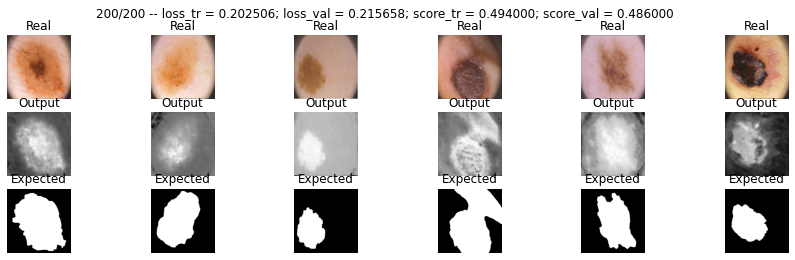

In [ ]:
unet2_focal = UNet2().to(device)
optimizer = torch.optim.Adam(unet2_focal.parameters())
history_unet2_focal = train(unet2_focal, optimizer, focal_loss, max_epochs, data_tr, data_val)
pd.DataFrame(history_unet2_focal).to_csv('/content/drive/MyDrive/HomeworkSegmentation/history_unet2_focal.csv')
torch.save(unet2_focal, '/content/drive/MyDrive/HomeworkSegmentation/unet2_focal.model')

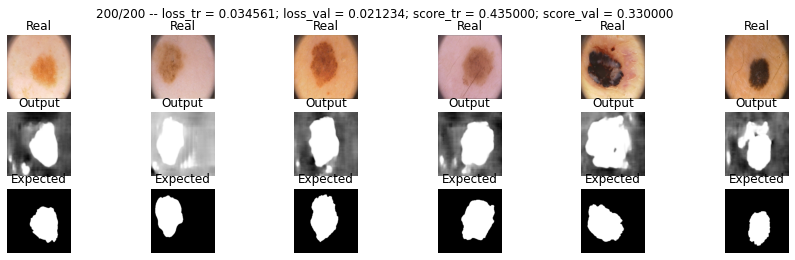

In [ ]:
unet2_correlation = UNet2().to(device)
optimizer = torch.optim.Adam(unet2_correlation.parameters())
history_unet2_correlation = train(unet2_correlation, optimizer, correlation_loss, max_epochs, data_tr, data_val)
pd.DataFrame(history_unet2_correlation).to_csv('/content/drive/MyDrive/HomeworkSegmentation/history_unet2_correlation.csv')
torch.save(unet2_correlation, '/content/drive/MyDrive/HomeworkSegmentation/unet2_correlation.model')

Сделайте вывод какая из моделей лучше

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

# Домашняя работа по теме &laquo;сегментация изображений&raquo;

Суркис Антон; Stepik id: [83694640](https://stepik.org/users/83694640)

In [16]:
import pandas as pd

# Можно восстановить историю обучения из сохраненных csv,
# если обучение проходило в несколько этапов с перезапусками ноутбука
history_segnet_bce = pd.read_csv('/content/drive/MyDrive/HomeworkSegmentation/history_segnet_bce.csv')
history_segnet_dice = pd.read_csv('/content/drive/MyDrive/HomeworkSegmentation/history_segnet_dice.csv')
history_segnet_focal = pd.read_csv('/content/drive/MyDrive/HomeworkSegmentation/history_segnet_focal.csv')
history_segnet_correlation = pd.read_csv('/content/drive/MyDrive/HomeworkSegmentation/history_segnet_correlation.csv')
history_unet_bce = pd.read_csv('/content/drive/MyDrive/HomeworkSegmentation/history_unet_bce.csv')
history_unet_dice = pd.read_csv('/content/drive/MyDrive/HomeworkSegmentation/history_unet_dice.csv')
history_unet_focal = pd.read_csv('/content/drive/MyDrive/HomeworkSegmentation/history_unet_focal.csv')
history_unet_correlation = pd.read_csv('/content/drive/MyDrive/HomeworkSegmentation/history_unet_correlation.csv')
history_unet2_bce = pd.read_csv('/content/drive/MyDrive/HomeworkSegmentation/history_unet2_bce.csv')
history_unet2_dice = pd.read_csv('/content/drive/MyDrive/HomeworkSegmentation/history_unet2_dice.csv')
history_unet2_focal = pd.read_csv('/content/drive/MyDrive/HomeworkSegmentation/history_unet2_focal.csv')
history_unet2_correlation = pd.read_csv('/content/drive/MyDrive/HomeworkSegmentation/history_unet2_correlation.csv')
# Можно не беспокоиться о смене типа со словаря массивов на DataFrame,
# т.к. дальнейший код обрабатывает их одинаково

# Также можно восстановить сами модели
segnet_bce = torch.load('/content/drive/MyDrive/HomeworkSegmentation/segnet_bce.model')
segnet_dice = torch.load('/content/drive/MyDrive/HomeworkSegmentation/segnet_dice.model')
segnet_focal = torch.load('/content/drive/MyDrive/HomeworkSegmentation/segnet_focal.model')
segnet_correlation = torch.load('/content/drive/MyDrive/HomeworkSegmentation/segnet_correlation.model')
unet_bce = torch.load('/content/drive/MyDrive/HomeworkSegmentation/unet_bce.model')
unet_dice = torch.load('/content/drive/MyDrive/HomeworkSegmentation/unet_dice.model')
unet_focal = torch.load('/content/drive/MyDrive/HomeworkSegmentation/unet_focal.model')
unet_correlation = torch.load('/content/drive/MyDrive/HomeworkSegmentation/unet_correlation.model')
unet2_bce = torch.load('/content/drive/MyDrive/HomeworkSegmentation/unet2_bce.model')
unet2_dice = torch.load('/content/drive/MyDrive/HomeworkSegmentation/unet2_dice.model')
unet2_focal = torch.load('/content/drive/MyDrive/HomeworkSegmentation/unet2_focal.model')
unet2_correlation = torch.load('/content/drive/MyDrive/HomeworkSegmentation/unet2_correlation.model')

## Графики каждой функции потерь и соответствующего score для каждой сети
строить их на одной оси бессмысленно, т.к. функции потерь не отнормированы и сходятся в разных точках

### SegNet

#### BCE

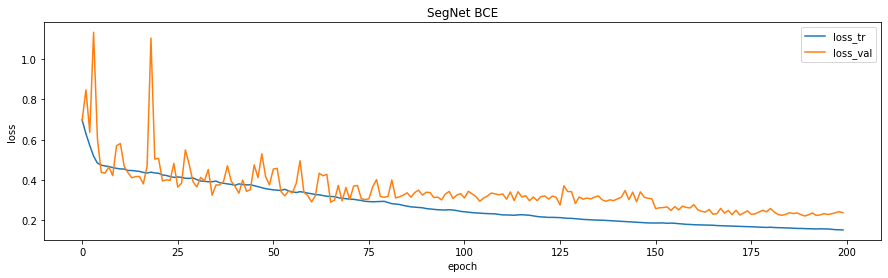

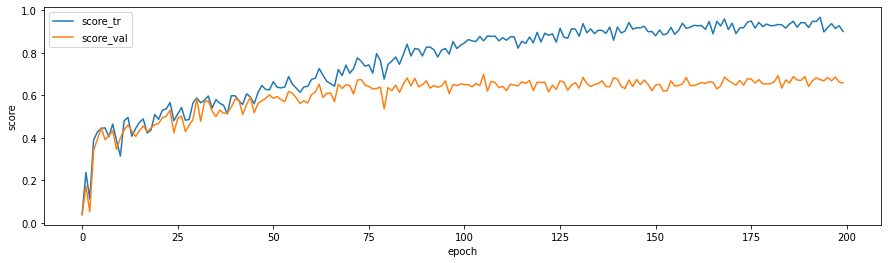

0.6260000348091126

In [ ]:
plt.title('SegNet BCE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history_segnet_bce['loss_tr'], label='loss_tr')
plt.plot(history_segnet_bce['loss_val'], label='loss_val')
plt.legend(loc='best')
plt.show()

plt.ylabel('score')
plt.xlabel('epoch')
plt.plot(history_segnet_bce['score_tr'], label='score_tr')
plt.plot(history_segnet_bce['score_val'], label='score_val')
plt.legend(loc='best')
plt.show()

# Метрика на тестовом датасете
score_model(segnet_bce, iou_pytorch, data_ts)

#### Dice

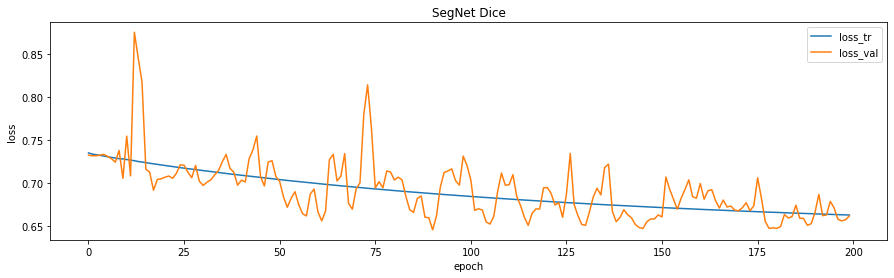

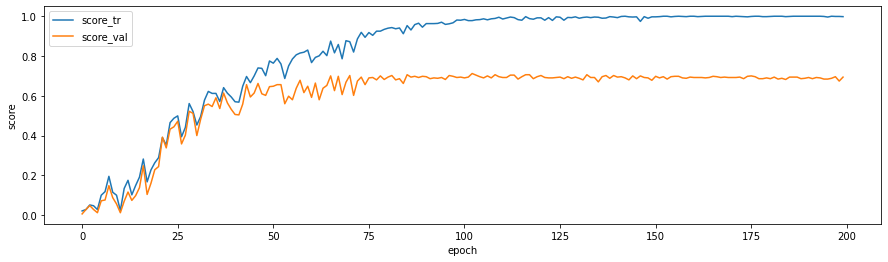

0.7100000143051147

In [ ]:
plt.title('SegNet Dice')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history_segnet_dice['loss_tr'], label='loss_tr')
plt.plot(history_segnet_dice['loss_val'], label='loss_val')
plt.legend(loc='best')
plt.show()

plt.ylabel('score')
plt.xlabel('epoch')
plt.plot(history_segnet_dice['score_tr'], label='score_tr')
plt.plot(history_segnet_dice['score_val'], label='score_val')
plt.legend(loc='best')
plt.show()

# Метрика на тестовом датасете
score_model(segnet_dice, iou_pytorch, data_ts)

#### Focal

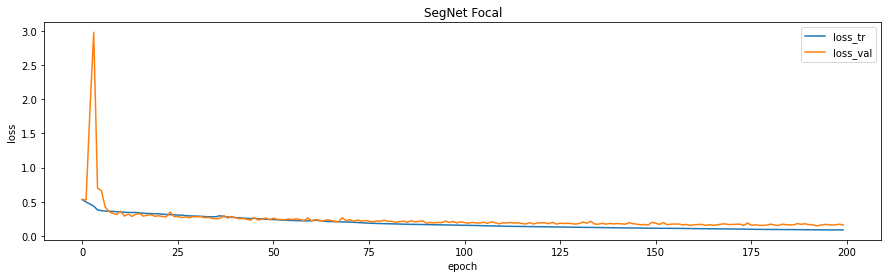

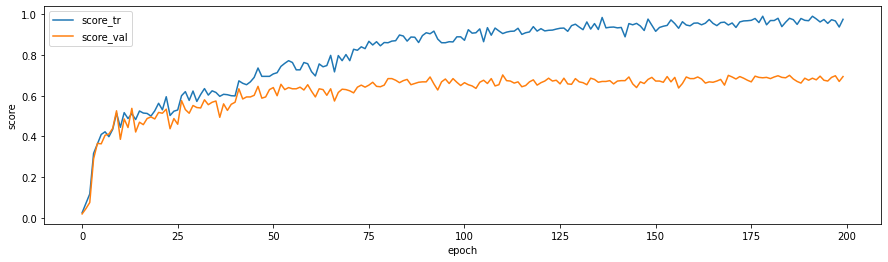

0.6860000133514405

In [ ]:
plt.title('SegNet Focal')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history_segnet_focal['loss_tr'], label='loss_tr')
plt.plot(history_segnet_focal['loss_val'], label='loss_val')
plt.legend(loc='best')
plt.show()

plt.ylabel('score')
plt.xlabel('epoch')
plt.plot(history_segnet_focal['score_tr'], label='score_tr')
plt.plot(history_segnet_focal['score_val'], label='score_val')
plt.legend(loc='best')
plt.show()

# Метрика на тестовом датасете
score_model(segnet_focal, iou_pytorch, data_ts)

#### Correlation

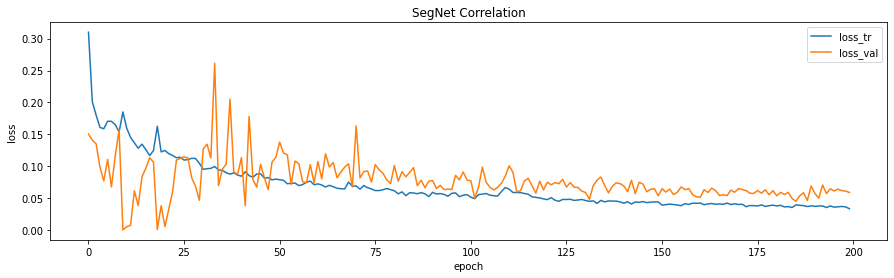

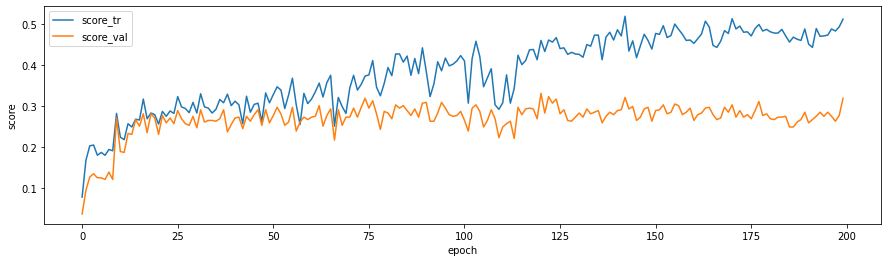

0.41400000751018523

In [ ]:
plt.title('SegNet Correlation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history_segnet_correlation['loss_tr'], label='loss_tr')
plt.plot(history_segnet_correlation['loss_val'], label='loss_val')
plt.legend(loc='best')
plt.show()

plt.ylabel('score')
plt.xlabel('epoch')
plt.plot(history_segnet_correlation['score_tr'], label='score_tr')
plt.plot(history_segnet_correlation['score_val'], label='score_val')
plt.legend(loc='best')
plt.show()

# Метрика на тестовом датасете
score_model(segnet_correlation, iou_pytorch, data_ts)

### UNet

#### BCE

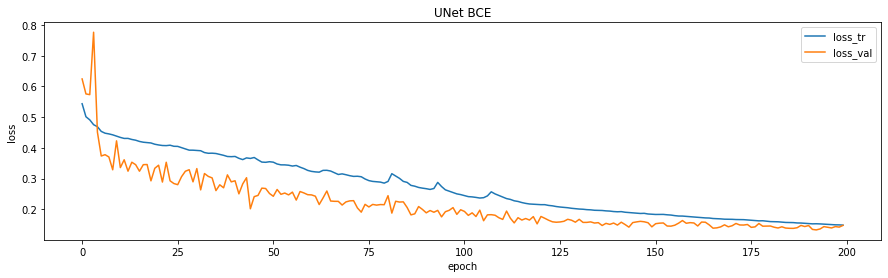

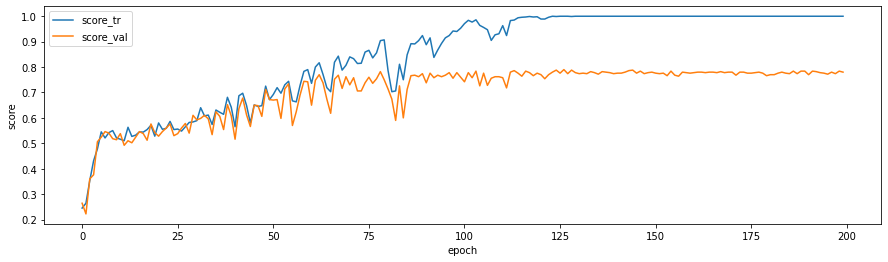

0.7480000376701355

In [ ]:
plt.title('UNet BCE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history_unet_bce['loss_tr'], label='loss_tr')
plt.plot(history_unet_bce['loss_val'], label='loss_val')
plt.legend(loc='best')
plt.show()

plt.ylabel('score')
plt.xlabel('epoch')
plt.plot(history_unet_bce['score_tr'], label='score_tr')
plt.plot(history_unet_bce['score_val'], label='score_val')
plt.legend(loc='best')
plt.show()

# Метрика на тестовом датасете
score_model(unet_bce, iou_pytorch, data_ts)

Можно заметить, что 0.748 &mdash; наибольшее значение метрики на тестовом наборе среди всех моделей и функций потерь.

#### Dice

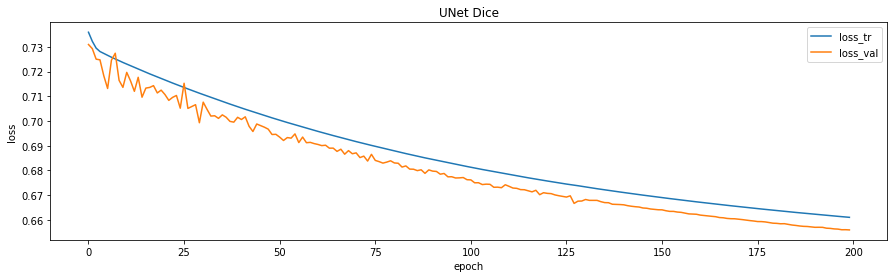

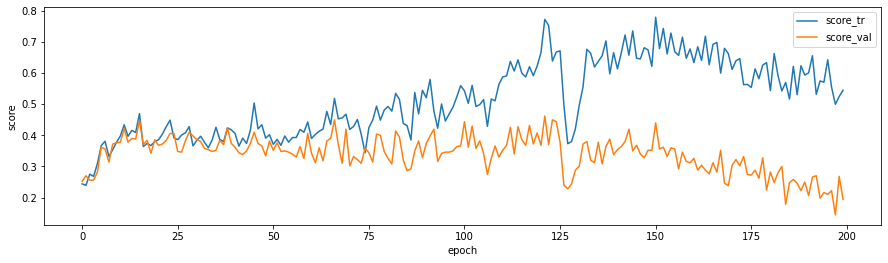

0.3940000018104911

In [ ]:
plt.title('UNet Dice')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history_unet_dice['loss_tr'], label='loss_tr')
plt.plot(history_unet_dice['loss_val'], label='loss_val')
plt.legend(loc='best')
plt.show()

plt.ylabel('score')
plt.xlabel('epoch')
plt.plot(history_unet_dice['score_tr'], label='score_tr')
plt.plot(history_unet_dice['score_val'], label='score_val')
plt.legend(loc='best')
plt.show()

# Метрика на тестовом датасете
score_model(unet_dice, iou_pytorch, data_ts)

#### Focal

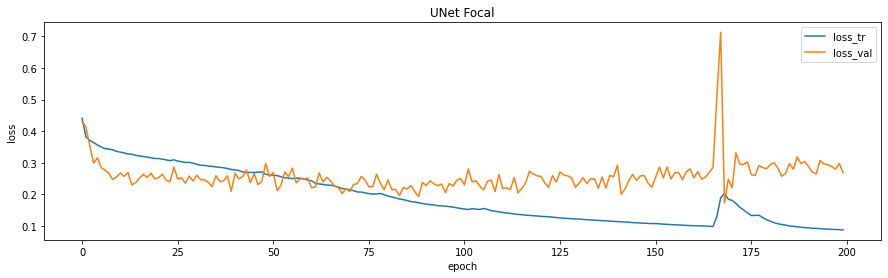

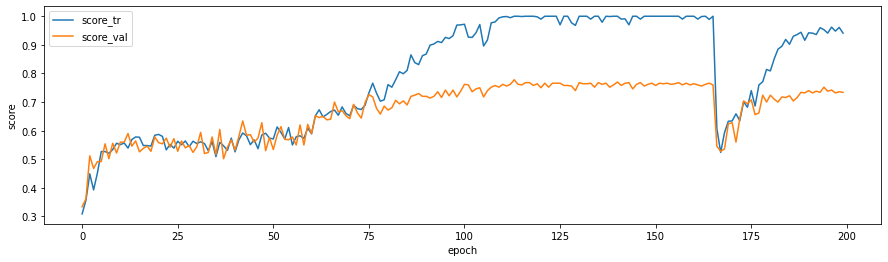

0.7200000286102295

In [ ]:
plt.title('UNet Focal')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history_unet_focal['loss_tr'], label='loss_tr')
plt.plot(history_unet_focal['loss_val'], label='loss_val')
plt.legend(loc='best')
plt.show()

plt.ylabel('score')
plt.xlabel('epoch')
plt.plot(history_unet_focal['score_tr'], label='score_tr')
plt.plot(history_unet_focal['score_val'], label='score_val')
plt.legend(loc='best')
plt.show()

# Метрика на тестовом датасете
score_model(unet_focal, iou_pytorch, data_ts)

Здесь можно заметить скачок метрики и функции потерь.
Предположительная причина: накопленный &laquo;импульс&raquo; оптимизатора
и высокое значение градиента функции потерь в локальной точке приводят к подобному &laquo;выхлопу&raquo;.

#### Correlation

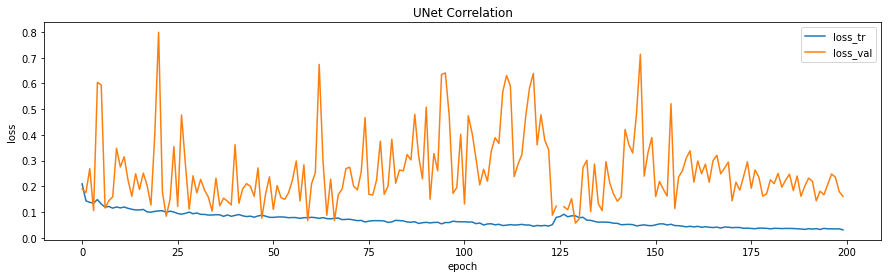

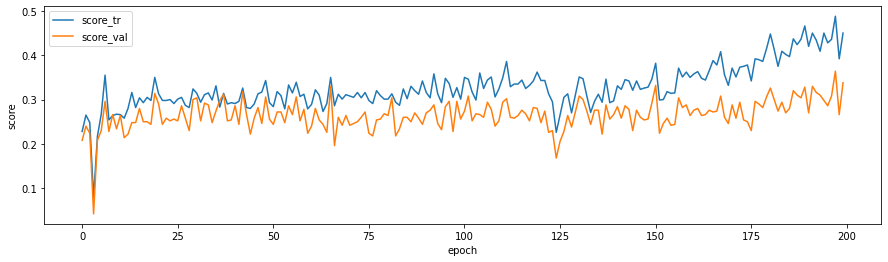

0.4980000197887421

In [ ]:
plt.title('UNet Correlation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history_unet_correlation['loss_tr'], label='loss_tr')
plt.plot(history_unet_correlation['loss_val'], label='loss_val')
plt.legend(loc='best')
plt.show()

plt.ylabel('score')
plt.xlabel('epoch')
plt.plot(history_unet_correlation['score_tr'], label='score_tr')
plt.plot(history_unet_correlation['score_val'], label='score_val')
plt.legend(loc='best')
plt.show()

# Метрика на тестовом датасете
score_model(unet_correlation, iou_pytorch, data_ts)

### UNet2

#### BCE

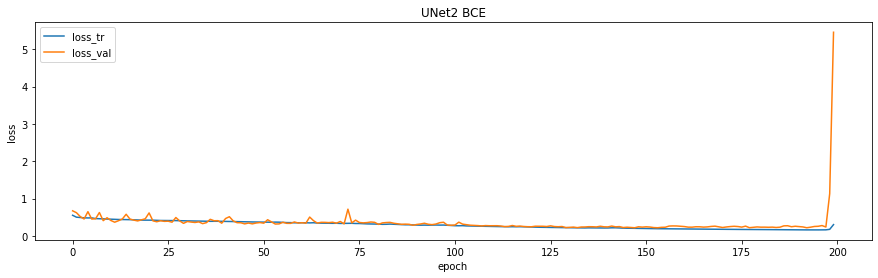

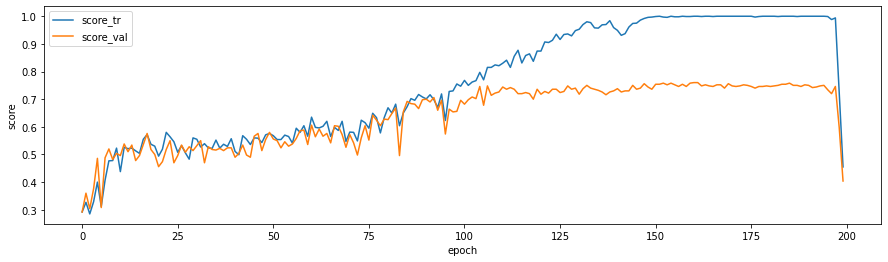

0.4680000126361847

In [ ]:
plt.title('UNet2 BCE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history_unet2_bce['loss_tr'], label='loss_tr')
plt.plot(history_unet2_bce['loss_val'], label='loss_val')
plt.legend(loc='best')
plt.show()

plt.ylabel('score')
plt.xlabel('epoch')
plt.plot(history_unet2_bce['score_tr'], label='score_tr')
plt.plot(history_unet2_bce['score_val'], label='score_val')
plt.legend(loc='best')
plt.show()

# Метрика на тестовом датасете
score_model(unet2_model, iou_pytorch, data_ts)

Здесь заметен аналогичный скачок оптимизатора, в этот раз он пришелся ровно на 200-ю эпоху обучения.
Однако, сравнивая графики (позже) можно увидеть, что UNet2 все равно проигрывает UNet при обучении с функцией потерь BCE.

Построим график функции потерь без двух последних эпох,
т.к. на предыдущем не видно, что она уменьшается из-за масштаба:

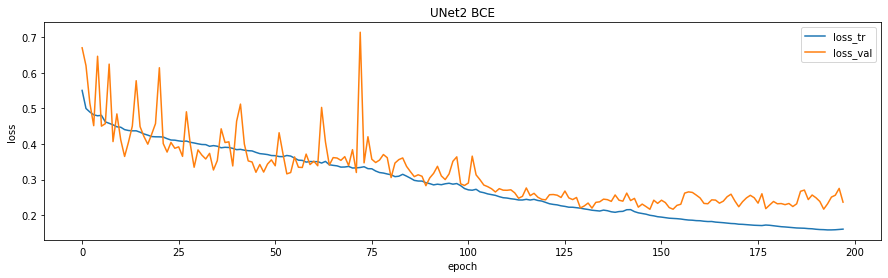

In [18]:
plt.title('UNet2 BCE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history_unet2_bce['loss_tr'][:-2], label='loss_tr')
plt.plot(history_unet2_bce['loss_val'][:-2], label='loss_val')
plt.legend(loc='best')
plt.show()

#### Dice

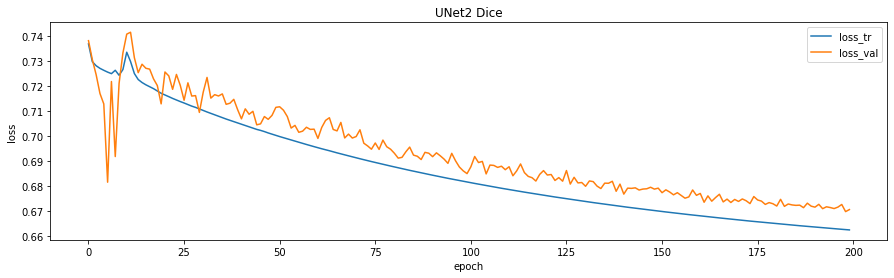

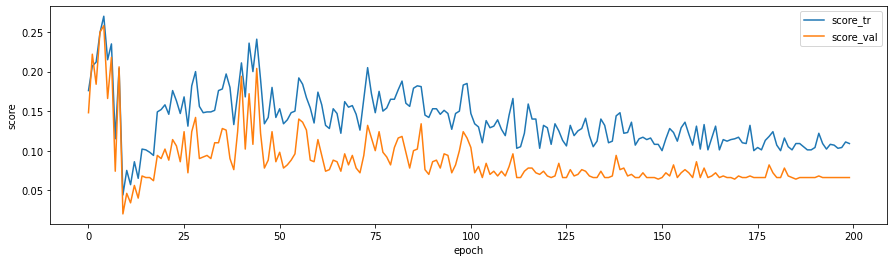

0.12400000747293234

In [ ]:
plt.title('UNet2 Dice')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history_unet2_dice['loss_tr'], label='loss_tr')
plt.plot(history_unet2_dice['loss_val'], label='loss_val')
plt.legend(loc='best')
plt.show()

plt.ylabel('score')
plt.xlabel('epoch')
plt.plot(history_unet2_dice['score_tr'], label='score_tr')
plt.plot(history_unet2_dice['score_val'], label='score_val')
plt.legend(loc='best')
plt.show()

# Метрика на тестовом датасете
score_model(unet2_dice, iou_pytorch, data_ts)

#### Focal

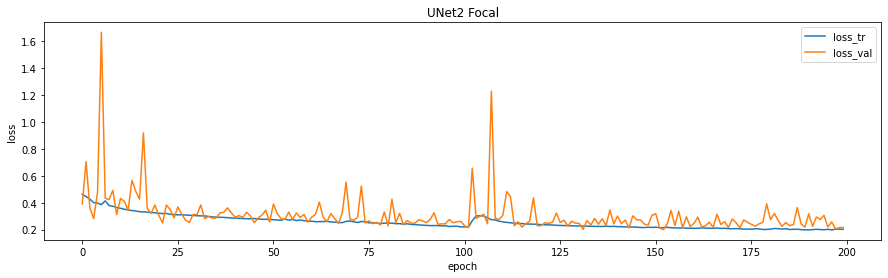

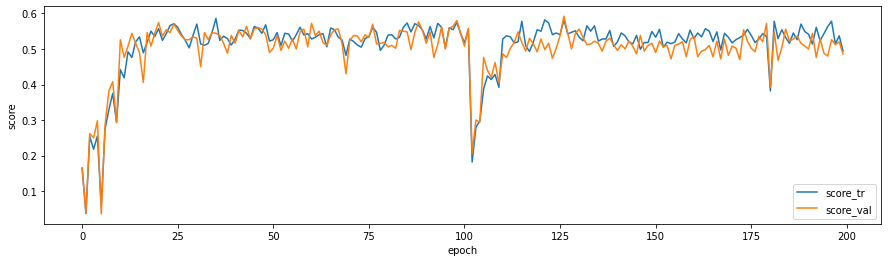

0.6040000259876251

In [ ]:
plt.title('UNet2 Focal')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history_unet2_focal['loss_tr'], label='loss_tr')
plt.plot(history_unet2_focal['loss_val'], label='loss_val')
plt.legend(loc='best')
plt.show()

plt.ylabel('score')
plt.xlabel('epoch')
plt.plot(history_unet2_focal['score_tr'], label='score_tr')
plt.plot(history_unet2_focal['score_val'], label='score_val')
plt.legend(loc='best')
plt.show()

# Метрика на тестовом датасете
score_model(unet2_focal, iou_pytorch, data_ts)

#### Correlation

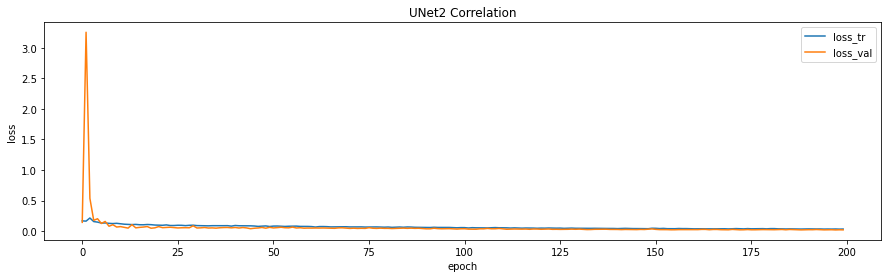

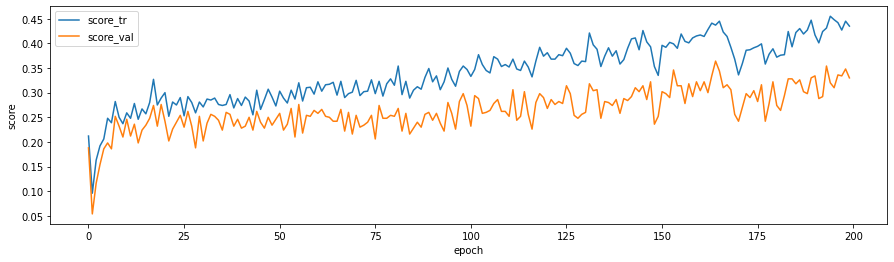

0.43800000548362733

In [ ]:
plt.title('UNet2 Correlation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history_unet2_correlation['loss_tr'], label='loss_tr')
plt.plot(history_unet2_correlation['loss_val'], label='loss_val')
plt.legend(loc='best')
plt.show()

plt.ylabel('score')
plt.xlabel('epoch')
plt.plot(history_unet2_correlation['score_tr'], label='score_tr')
plt.plot(history_unet2_correlation['score_val'], label='score_val')
plt.legend(loc='best')
plt.show()

# Метрика на тестовом датасете
score_model(unet2_correlation, iou_pytorch, data_ts)

Снова построим график функции потерь только по части эпох,
на этот раз &laquo;откусывая&raquo; начало:

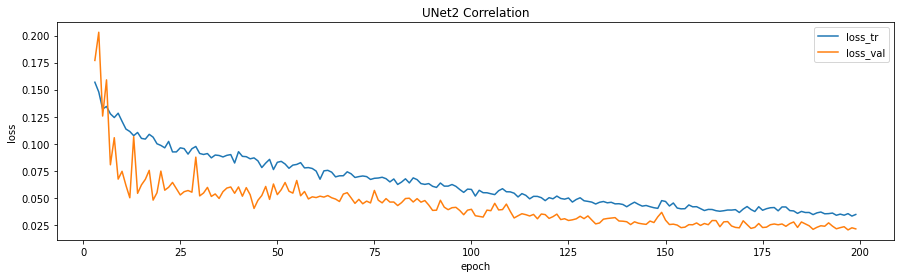

In [23]:
plt.title('UNet2 Correlation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history_unet2_correlation['loss_tr'][3:], label='loss_tr')
plt.plot(history_unet2_correlation['loss_val'][3:], label='loss_val')
plt.legend(loc='best')
plt.show()

Можно заметить, что снижение функции потерь в целом происходит,
но слишком медленно для практического применения.

## Графики score
Метрики уже имеет смысл сравнивать, т.к. используем одну и ту же метрику как эталон оценки качества модели.
При этом по предполагаемым условиям график мы можем построить только по валидационному, но не тестовому датасету, поскольку возможности взять метрики по последнему во время обучения обычно нет.

### По сетям

#### SegNet

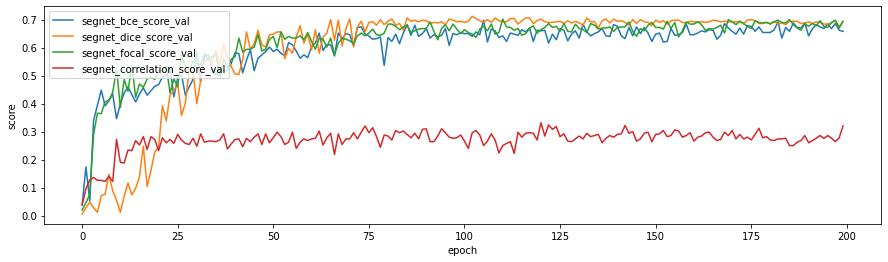

In [24]:
plt.ylabel('score')
plt.xlabel('epoch')
plt.plot(history_segnet_bce['score_val'], label='segnet_bce_score_val')
plt.plot(history_segnet_dice['score_val'], label='segnet_dice_score_val')
plt.plot(history_segnet_focal['score_val'], label='segnet_focal_score_val')
plt.plot(history_segnet_correlation['score_val'], label='segnet_correlation_score_val')
plt.legend(loc='upper left')
plt.show()

#### UNet

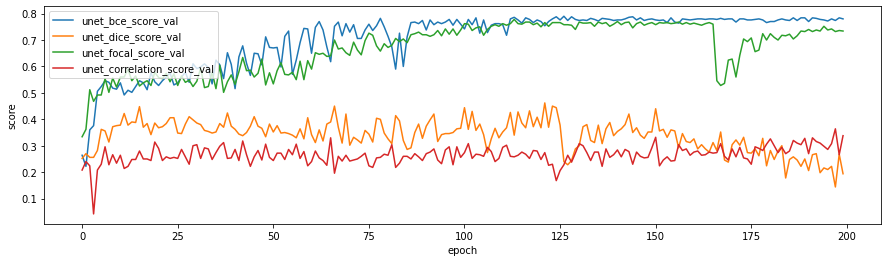

In [25]:
plt.ylabel('score')
plt.xlabel('epoch')
plt.plot(history_unet_bce['score_val'], label='unet_bce_score_val')
plt.plot(history_unet_dice['score_val'], label='unet_dice_score_val')
plt.plot(history_unet_focal['score_val'], label='unet_focal_score_val')
plt.plot(history_unet_correlation['score_val'], label='unet_correlation_score_val')
plt.legend(loc='upper left')
plt.show()

#### UNet2

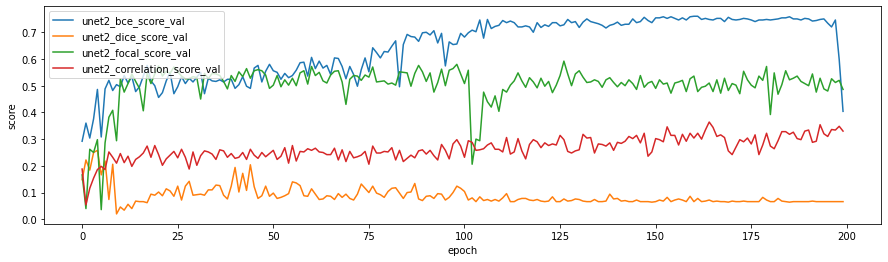

In [26]:
plt.ylabel('score')
plt.xlabel('epoch')
plt.plot(history_unet2_bce['score_val'], label='unet2_bce_score_val')
plt.plot(history_unet2_dice['score_val'], label='unet2_dice_score_val')
plt.plot(history_unet2_focal['score_val'], label='unet2_focal_score_val')
plt.plot(history_unet2_correlation['score_val'], label='unet2_correlation_score_val')
plt.legend(loc='upper left')
plt.show()

### По функциям потерь

#### BCE

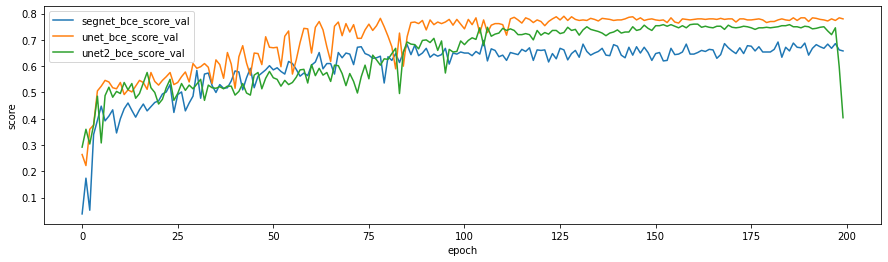

In [27]:
plt.ylabel('score')
plt.xlabel('epoch')
plt.plot(history_segnet_bce['score_val'], label='segnet_bce_score_val')
plt.plot(history_unet_bce['score_val'], label='unet_bce_score_val')
plt.plot(history_unet2_bce['score_val'], label='unet2_bce_score_val')
plt.legend(loc='upper left')
plt.show()

Можно заметить, что UNet показывает лучший счет с BCE, около 0.8,
немного отстает UNet2, но на последней эпохе &laquo;глупеет&raquo;.
Эта аномалия не влияет на то, что UNet2 проигрывает UNet,
но полезно учитывать возможность подобных аномалий и важность построения именно графика, а не только сравнивания последних значений при, например, выборе, какую нейросеть обучать, например, на большем количестве эпох или большем датасете, что невозможно сделать для всех сетей в силу ограниченности ресурсов.
SegNet показывает стабильный score, но сильно ниже UNet.


#### Dice

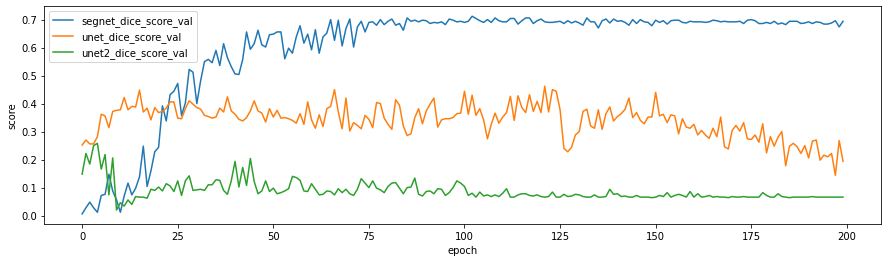

In [29]:
plt.ylabel('score')
plt.xlabel('epoch')
plt.plot(history_segnet_dice['score_val'], label='segnet_dice_score_val')
plt.plot(history_unet_dice['score_val'], label='unet_dice_score_val')
plt.plot(history_unet2_dice['score_val'], label='unet2_dice_score_val')
plt.legend(loc='upper left')
plt.show()

С Dice наилучший счет показывает SegNet, около 0.7,
UNet и UNet2 почти не обучаются.

#### Focal

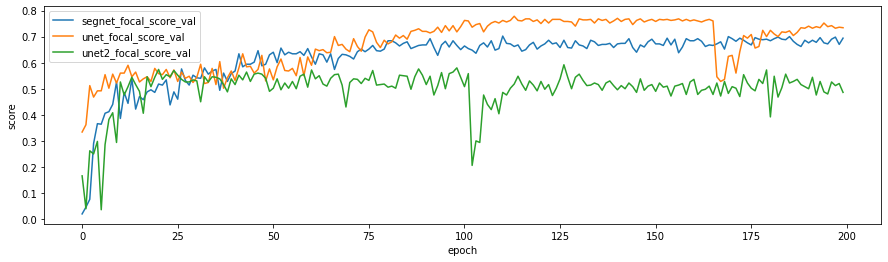

In [30]:
plt.ylabel('score')
plt.xlabel('epoch')
plt.plot(history_segnet_focal['score_val'], label='segnet_focal_score_val')
plt.plot(history_unet_focal['score_val'], label='unet_focal_score_val')
plt.plot(history_unet2_focal['score_val'], label='unet2_focal_score_val')
plt.legend(loc='upper left')
plt.show()

Лучший score при фокусной функции потерь &mdash; у UNet, но при этом между 150 и 175 эпохой происходит значительный провал.
UNet2 сильно отстает, SegNet стабилен, но тоже отстает.

#### Correlation

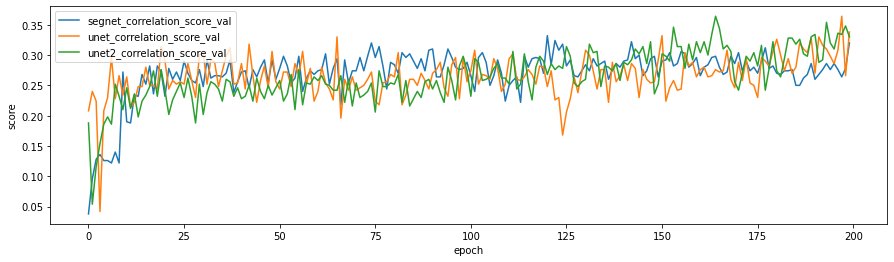

In [31]:
plt.ylabel('score')
plt.xlabel('epoch')
plt.plot(history_segnet_correlation['score_val'], label='segnet_correlation_score_val')
plt.plot(history_unet_correlation['score_val'], label='unet_correlation_score_val')
plt.plot(history_unet2_correlation['score_val'], label='unet2_correlation_score_val')
plt.legend(loc='upper left')
plt.show()

Correlation score нестабилен у всех трех сетей, и показывает слабый результат.
Возможно, это связано с тем, что он предназначен для менее четкой сегментации,
но т.к. здесь мы сегментируем поражения кожи, то нужна высокая четкость.

## Итоговое сравнение

По предыдущим двум группам наиболее явно ситуацию с метриками отражала группировка по функциям потерь, поэтому возьмем лучшие сети из этих групп: UNet BCE, SegNet Diccei и UNet Focal (Correlation можно не брать, т.к. явно видно слишком низкий счет).
Стоит отметить, что эти же модели выдают наиболее четкие карты сегментации,
что можно видеть в визуализации их обучения.

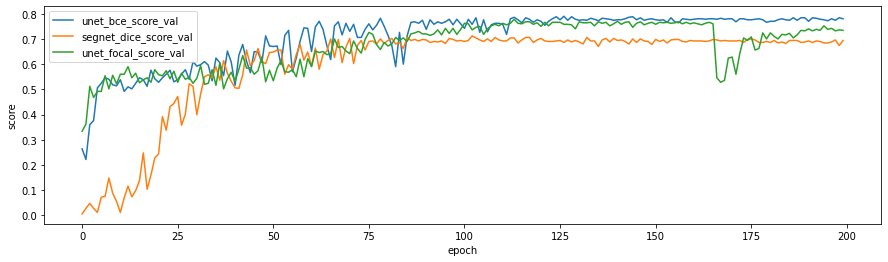

In [32]:
plt.ylabel('score')
plt.xlabel('epoch')
plt.plot(history_unet_bce['score_val'], label='unet_bce_score_val')
plt.plot(history_segnet_dice['score_val'], label='segnet_dice_score_val')
plt.plot(history_unet_focal['score_val'], label='unet_focal_score_val')
plt.legend(loc='upper left')
plt.show()

UNet с Focal loss в целом сравним по качеству с UNet BCE,
но из графика видно, что все же немного отстает даже до проседания.
SegNet Dice значительно отстает от обоих, хотя и был лучшим в своей группе.

## Вывод

Наилучшей нейросетью для задачи сегментации поврежденных участков кожи оказалась UNet (с пулингами), обученная с функцией потерь BCE, как по метрикам на тестовом датасете (отображены снизу от графиков функций потерь) &mdash; 0.748, что является лучшим результатом, так и по графикам метрик потерь на валидационном датасете &mdash; модель явно опережает остальные на валидационном датасете.

Приблизительное время обучения до сходимости у всех сетей на всех функциях потерь в данном задании &mdash; 125-150 эпох. Я брал 200, т.е. со значительным запасом, поскольку проводил исследование и этой информации у меня еще не было.

Во время анализа графиков я обнаружил аномалию &laquo;выброса&raquo; модели из локального минимума функции потерь при оптимизации, это нужно учитывать при выборе модели для дальнейшего обучения в других проектах.